Improving the post-processing after dsm experiments..as there are algos which can enhance ridge features from dsms ...Going to use all of them in tandem to come up with an algo that will close most of the edges.

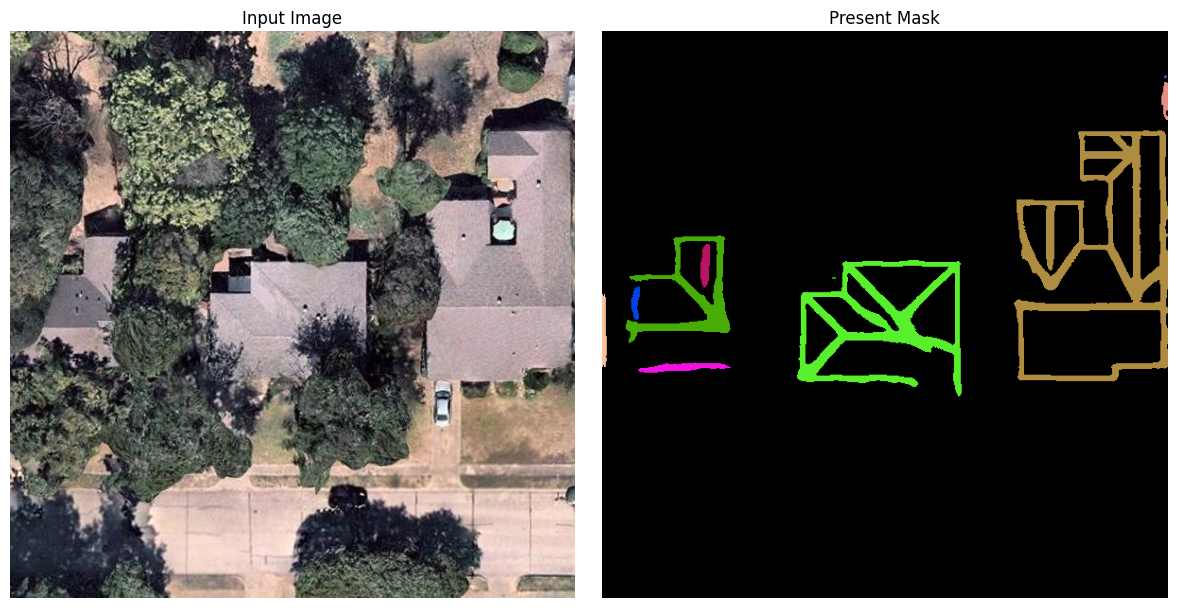

In [1]:
import matplotlib.pyplot as plt
import rasterio
from PIL import Image
import numpy as np

# Paths to images
tiff_path = "32.884040299999995_-96.64130139999999_nearmap_rgb.tif"
png_path = "32.884040299999995_-96.64130139999999_nearmap_rgb_connected.png"

# Load TIFF image
with rasterio.open(tiff_path) as src:
    tiff_image = src.read()  # Read all bands
    tiff_image = np.transpose(tiff_image, (1, 2, 0))  # Change to (H, W, C) if multi-channel

# Load PNG image
png_image = Image.open(png_path)
png_image = np.array(png_image)

# Plot the images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display TIFF
axes[0].imshow(tiff_image)
axes[0].set_title("Input Image")
axes[0].axis("off")

# Display PNG
axes[1].imshow(png_image)
axes[1].set_title("Present Mask")
axes[1].axis("off")

plt.tight_layout()
plt.show()


The mask does not have connected polygons hence has missing facets that could be marked

Using the exisiting post-processing on the extracted masks

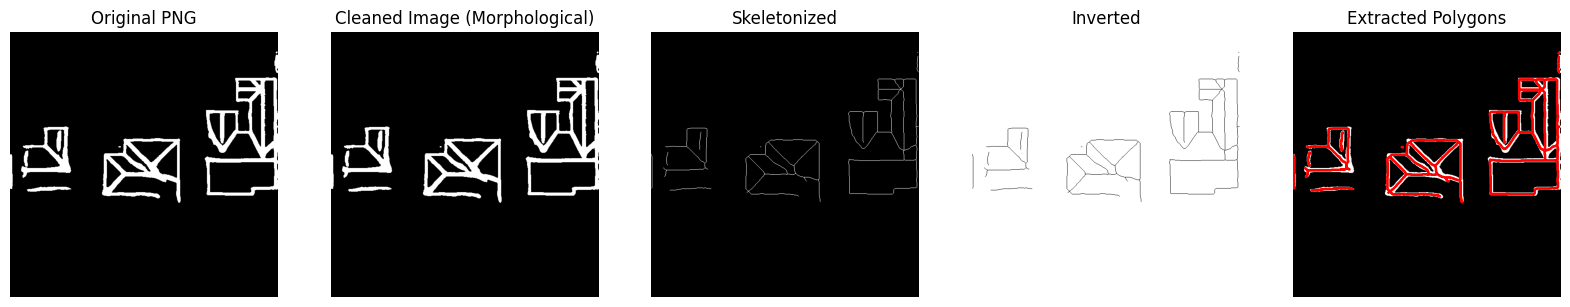

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import binary_opening, skeletonize
from skimage.measure import find_contours
from shapely.geometry import Polygon

# 🔹 Load PNG and Convert to Binary Mask
def load_and_preprocess_png(png_path):
    img = cv2.imread(png_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
    img = cv2.resize(img, (600, 596))  # Resize if necessary
    binary_img = (img > 0).astype(np.uint8)  # Convert to binary mask (0 or 1)
    return binary_img

# 🔹 Apply Morphological Opening to Remove Noise
def clean_binary_image(binary_img):
    cleaned_img = binary_opening(binary_img)  # Uses default structuring element
    return cleaned_img

# 🔹 Skeletonize the Binary Image
def skeletonize_image(binary_img):
    return skeletonize(binary_img)

# 🔹 Invert Image for Better Contour Detection
def invert_image(binary_img):
    return 1 - binary_img  # Inverts binary image (0s become 1s and vice versa)

# 🔹 Extract Polygons from Processed Image
def extract_polygons_from_mask(binary_img):
    polygons = []
    contours = find_contours(binary_img, level=0.5)

    for contour in contours:
        coords = [(y,x) for x, y in contour] #numpy is y,x for top left
        if len(coords) > 2 and coords[0] != coords[-1]:  # Ensure closed polygon
            coords.append(coords[0])
        if len(coords) >= 3:
            poly = Polygon(coords)
            polygons.append(poly)

    return polygons

# 🔹 Visualize the Image Processing Steps
def visualize_steps(original, cleaned, skeletonized, inverted, extracted_polygons):
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))

    axes[0].imshow(original, cmap="gray")
    axes[0].set_title("Original PNG")

    axes[1].imshow(cleaned, cmap="gray")
    axes[1].set_title("Cleaned Image (Morphological)")

    axes[2].imshow(skeletonized, cmap="gray")
    axes[2].set_title("Skeletonized")

    axes[3].imshow(inverted, cmap="gray")
    axes[3].set_title("Inverted")

    axes[4].imshow(original, cmap="gray")
    for poly in extracted_polygons:
        x, y = poly.exterior.xy
        axes[4].plot(x, y, color="red")
    axes[4].set_title("Extracted Polygons")

    for ax in axes:
        ax.axis("off")

    plt.show()

# 🔹 Run the Process on a PNG File
def main(png_path):
    original = load_and_preprocess_png(png_path)
    cleaned = clean_binary_image(original)
    skeletonized = skeletonize_image(cleaned)
    inverted = invert_image(skeletonized)
    polygons = extract_polygons_from_mask(inverted)

    visualize_steps(original, cleaned, skeletonized, inverted, polygons)
    return cleaned

# 🔹 Run on a Sample PNG
#png_file = "merged_mask.png" 
png_file = "32.884040299999995_-96.64130139999999_nearmap_rgb_connected.png"  # Change this to your PNG file path
cleaned=main(png_file)


Getting a masked DSM..filtering out only the roofs and clearing out all obstruction and other things.

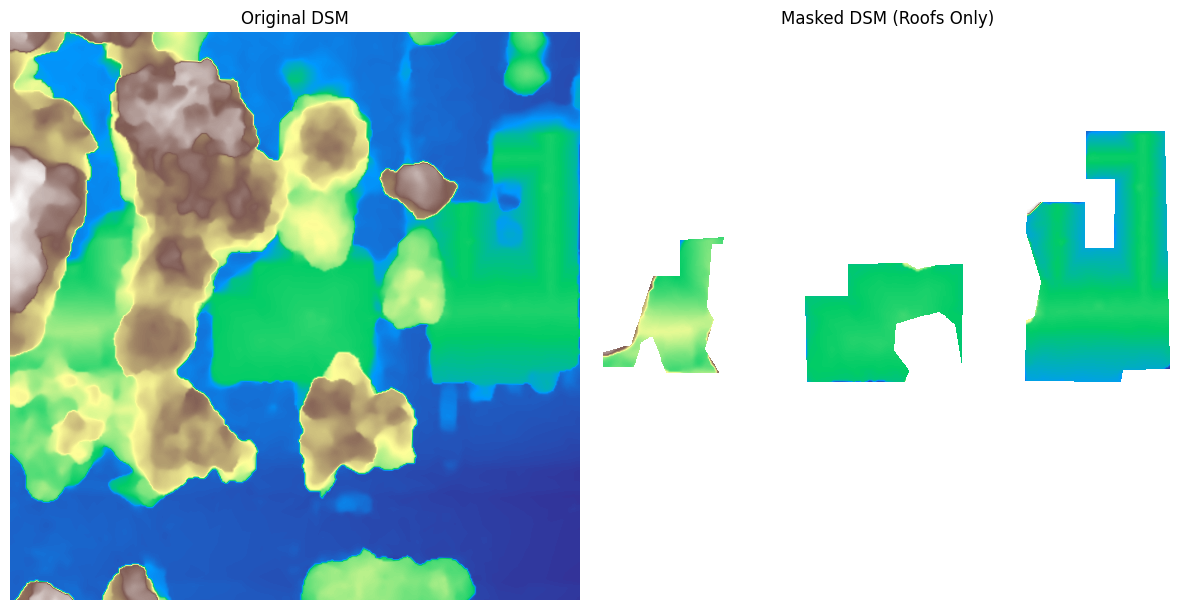

In [3]:
import numpy as np
import json
import cv2
import matplotlib.pyplot as plt
import rasterio

def load_tiff(file_path):
    """Load a TIFF file and return the first band as a 2D numpy array."""
    with rasterio.open(file_path) as dataset:
        image = dataset.read(1)  # Read only the first band (H, W)
        profile = dataset.profile  # Get metadata
    return image, profile

def load_json_annotations(json_path, dsm_shape):
    """
    Load JSON annotation file and create a binary mask for roofs.

    Parameters:
    - json_path: Path to the annotation JSON file.
    - dsm_shape: Tuple (H, W) of the DSM.

    Returns:
    - mask: Binary numpy array (1 for roof pixels, 0 for others).
    """
    with open(json_path, 'r') as f:
        annotations = json.load(f)

    mask = np.zeros(dsm_shape, dtype=np.uint8)

    for obj in annotations['shapes']:
        if obj['label'] == 'roof':  # Only process roof annotations
            polygon = np.array(obj['points'], dtype=np.int32)  # Convert points to NumPy array
            cv2.fillPoly(mask, [polygon], 1)  # Fill polygon in mask

    return mask

def apply_roof_mask(dsm, mask):
    """
    Applies the roof mask to the DSM, setting non-roof areas to NaN.

    Parameters:
    - dsm: 2D numpy array of the DSM.
    - mask: Binary 2D mask (1 for roofs, 0 for others).

    Returns:
    - dsm_masked: DSM with non-roof areas set to NaN.
    """
    dsm_masked = np.where(mask == 1, dsm, np.nan)  # Set non-roof areas to NaN
    return dsm_masked

# Example Usage
json_path = "32.884040299999995_-96.64130139999999_nearmap_rgb.json"  # Replace with your actual path
dsm_path = "32.884040299999995_-96.64130139999999_nearmap_dsm.tif"

# Load DSM and Mask
dsm, dsm_profile = load_tiff(dsm_path)
mask = load_json_annotations(json_path, dsm.shape)  # Generate mask from JSON
dsm_masked = apply_roof_mask(dsm, mask)  # Apply mask

# Resize for Visualization (if needed)
target_size = (600, 598)
dsm_resized = cv2.resize(dsm, target_size, interpolation=cv2.INTER_NEAREST)
dsm_masked_resized = cv2.resize(dsm_masked, target_size, interpolation=cv2.INTER_NEAREST)

# Visualization
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(dsm_resized, cmap='terrain')
plt.title("Original DSM")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(dsm_masked_resized, cmap='terrain')
plt.title("Masked DSM (Roofs Only)")
plt.axis("off")

plt.tight_layout()
plt.show()


In [4]:

def save_tiff(output_path, data, profile):
    """Save the masked DSM as a GeoTIFF."""
    profile.update(dtype="float32", nodata=np.nan)  # Ensure correct metadata

    with rasterio.open(output_path, "w", **profile) as dst:
        dst.write(data, 1)  # Write single-band DSM

    print(f"✅ Masked DSM saved at: {output_path}")

save_tiff("masked_dsm.tif", dsm_masked, dsm_profile)

✅ Masked DSM saved at: masked_dsm.tif


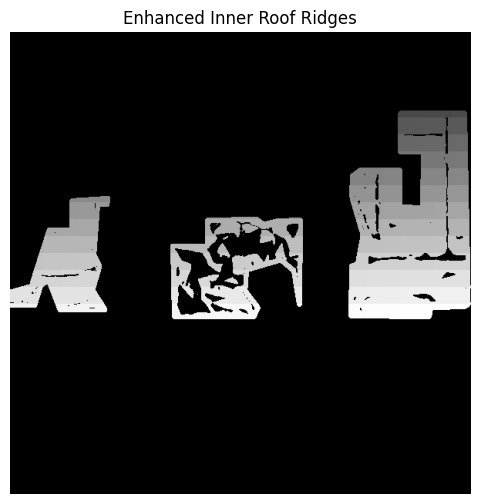

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor
from skimage.segmentation import slic, watershed
from skimage.util import img_as_ubyte

def dsm_to_point_cloud(dsm):
    """ Convert DSM to 3D point cloud (x, y, height), ignoring NaNs. """
    h, w = dsm.shape
    x, y = np.meshgrid(np.arange(w), np.arange(h))
    points = np.column_stack((x.ravel(), y.ravel(), dsm.ravel()))

    # 🔹 Remove points where DSM height is NaN
    points = points[~np.isnan(points[:, 2])]

    return points, h, w

def fit_planes_ransac_dynamic(points, h, w, min_points=500, threshold=0.3):
    """ Fit planes iteratively using RANSAC """
    planes = []
    inlier_masks = []
    remaining_points = points.copy()

    while len(remaining_points) > min_points:
        model = RANSACRegressor(residual_threshold=threshold)
        model.fit(remaining_points[:, :2], remaining_points[:, 2])  

        inliers = model.inlier_mask_
        if np.sum(inliers) < min_points:
            break

        planes.append(model.estimator_.coef_)
        inlier_mask = np.zeros((h, w), dtype=bool)
        x_idx = np.clip(remaining_points[:, 0].astype(int), 0, w - 1)
        y_idx = np.clip(remaining_points[:, 1].astype(int), 0, h - 1)
        inlier_mask[y_idx, x_idx] = inliers
        inlier_masks.append(inlier_mask)

        remaining_points = remaining_points[~inliers]

    return planes, inlier_masks

def extract_ridges(dsm, inlier_masks):
    """ Extract inner roof ridges using multi-scale filters and segmentation. """
    h, w = dsm.shape
    ridge_map = np.zeros((h, w), dtype=np.uint8)

    # 🔹 Replace NaNs with the min DSM value (or 0)
    dsm = np.where(np.isnan(dsm), np.nanmin(dsm), dsm).astype(np.float32)

    # Multi-scale gradient filtering
    grad_x_small = cv2.Sobel(dsm, cv2.CV_32F, 1, 0, ksize=3)
    grad_y_small = cv2.Sobel(dsm, cv2.CV_32F, 0, 1, ksize=3)
    grad_x_large = cv2.Sobel(dsm, cv2.CV_32F, 1, 0, ksize=7)
    grad_y_large = cv2.Sobel(dsm, cv2.CV_32F, 0, 1, ksize=7)

    # Combine multi-scale gradients
    gradient_magnitude = np.sqrt((grad_x_small**2 + grad_y_small**2) + (grad_x_large**2 + grad_y_large**2))

    # Adaptive thresholding to capture ridges
    ridge_threshold = np.percentile(gradient_magnitude, 85)
    ridge_map[gradient_magnitude > ridge_threshold] = 255

    # Laplacian to enhance inner edges
    laplacian = cv2.Laplacian(dsm, cv2.CV_32F, ksize=3)
    laplacian = cv2.convertScaleAbs(laplacian)
    ridge_map = np.maximum(ridge_map, laplacian)

    # 🔹 Ensure no NaNs before segmentation
    dsm_filled = np.where(np.isnan(dsm), 0, dsm)  # Replace NaNs with 0 for SLIC

    # Apply SLIC segmentation for refined ridge grouping
    #num_segments = max(h * w // 800, 200)  # Increase segments for better small structure handling
    #compactness_value = 5 if np.std(dsm_filled) < 1 else 15  # More compactness for low-variance areas
    #slic_segments = slic(dsm_filled, n_segments=num_segments, compactness=compactness_value, start_label=0, channel_axis=None)

    num_segments = max(h * w // 500, 150)
    slic_segments = slic(dsm_filled, n_segments=num_segments, compactness=10, start_label=0, channel_axis=None)


    # Use watershed segmentation on SLIC edges
    markers = slic_segments + 1
    watershed_segmentation = watershed(-ridge_map, markers, mask=ridge_map > 0)

    return watershed_segmentation

# Load masked DSM
# dsm_masked = np.load("your_masked_dsm.npy")

# Convert to point cloud
points, h, w = dsm_to_point_cloud(dsm_masked)

# Adaptive RANSAC Plane Extraction
planes, inlier_masks = fit_planes_ransac_dynamic(points, h, w, min_points=500, threshold=0.3)

# Extract ridges
ridge_map = extract_ridges(dsm_masked, inlier_masks)

# Visualize
plt.figure(figsize=(8, 6))
plt.imshow(ridge_map, cmap='gray')
plt.title("Enhanced Inner Roof Ridges")
plt.axis('off')
plt.show()

This is fine but need more richness to ai in post-processing.

Two ways :

1. Take the output mask after polygon extracrtion and complete the lines with the help of dsm
2. Use the building footprint to complete the lines

Exploring building mask and Edges detection

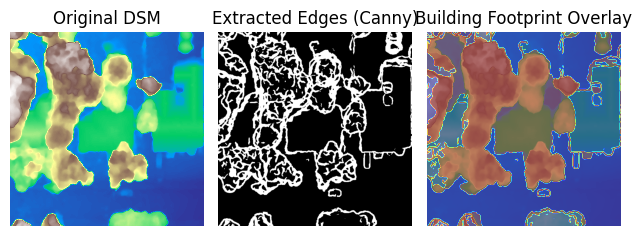

In [6]:
import cv2
import numpy as np


def extract_building_polygons(edge_map):
    """Convert edge-detected buildings to polygon masks."""
    contours, _ = cv2.findContours(edge_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(edge_map)
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
    return mask

def extract_ridges(dsm):
    """ Extract roof ridges using Scharr filtering, morphological operations, and adaptive thresholding. """
    h, w = dsm.shape

    # 🔹 Apply Scharr Filter (More Sensitive than Sobel)
    grad_x = cv2.Scharr(dsm, cv2.CV_32F, 1, 0)  # Horizontal edges
    grad_y = cv2.Scharr(dsm, cv2.CV_32F, 0, 1)  # Vertical edges
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

    # 🔹 Morphological Top-Hat Transform (Enhances Ridges)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))  # Large kernel to extract ridges
    top_hat = cv2.morphologyEx(dsm, cv2.MORPH_TOPHAT, kernel)

    # 🔹 Adaptive Thresholding to Keep Only Strongest Ridges
    ridge_map = np.zeros((h, w), dtype=np.uint8)
    ridge_threshold = np.percentile(gradient_magnitude, 75)  # Lowered from 85 to 75 for sensitivity
    ridge_map[gradient_magnitude > ridge_threshold] = 255

    # 🔹 Combine Results (Top-Hat + Gradient Detection)
    ridge_map = np.maximum(ridge_map, top_hat.astype(np.uint8))

    return ridge_map

building_edges = extract_ridges(dsm)
building_mask = extract_building_polygons(building_edges)

plt.subplot(1, 3, 1)
plt.imshow(dsm, cmap="terrain")
plt.title("Original DSM")
plt.axis("off")

# Detected Edges
plt.subplot(1, 3, 2)
plt.imshow(building_edges, cmap="gray")
plt.title("Extracted Edges (Canny)")
plt.axis("off")

# Final Building Mask
plt.subplot(1, 3, 3)
plt.imshow(dsm, cmap="terrain", alpha=0.7)  # Overlay on DSM
plt.imshow(building_mask, cmap="jet", alpha=0.5)
plt.title("Building Footprint Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()


C:\Users\adity\AppData\Local\Temp\ipykernel_20232\1600191765.py:18: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  frangi_filtered = frangi(high_pass, scale_range=(1, 5), scale_step=2, black_ridges=False)
C:\Users\adity\AppData\Local\Temp\ipykernel_20232\1600191765.py:19: RuntimeWarning: invalid value encountered in cast
  frangi_filtered = (frangi_filtered * 255).astype(np.uint8)  # Normalize to 0-255


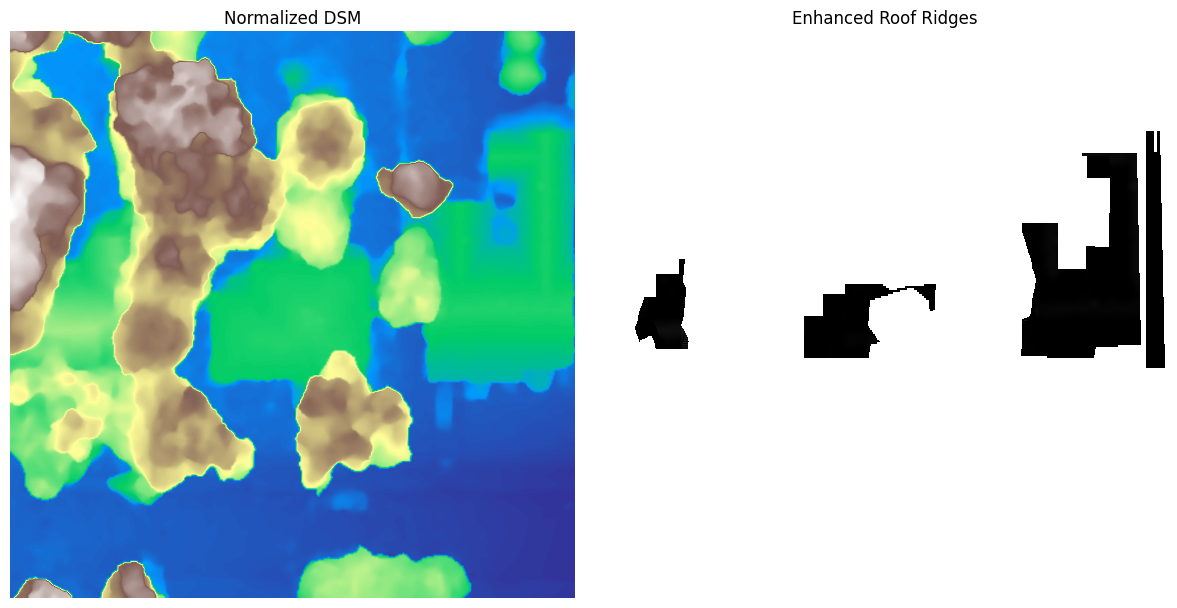

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from skimage.filters import frangi



def enhance_roof_ridges(dsm):
    """ Enhance roof ridges using high-pass filtering and Frangi filtering. """
    h, w = dsm.shape

    # 🔹 Step 1: High-Pass Filtering to Extract Fine Details
    dsm_blurred = cv2.GaussianBlur(dsm, (15, 15), 0)
    high_pass = cv2.subtract(dsm, dsm_blurred)  # Removes low-frequency details

    # 🔹 Step 2: Frangi Filter (Detects Tube-Like Structures Like Ridges)
    frangi_filtered = frangi(high_pass, scale_range=(1, 5), scale_step=2, black_ridges=False)
    frangi_filtered = (frangi_filtered * 255).astype(np.uint8)  # Normalize to 0-255

    # 🔹 Step 3: White Top-Hat Morphology (Enhances Bright Ridges)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 25))
    top_hat = cv2.morphologyEx(dsm, cv2.MORPH_TOPHAT, kernel)

    # 🔹 Step 4: Combine Filters for Final Ridge Map
    ridge_map = np.maximum(frangi_filtered, top_hat)

    return ridge_map



# 🔹 Extract Roof Ridges
ridge_map = enhance_roof_ridges(dsm_masked)

# 🔹 Visualization
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(dsm, cmap="terrain")
plt.title("Normalized DSM")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ridge_map, cmap="gray")
plt.title("Enhanced Roof Ridges")
plt.axis("off")

plt.tight_layout()
plt.show()


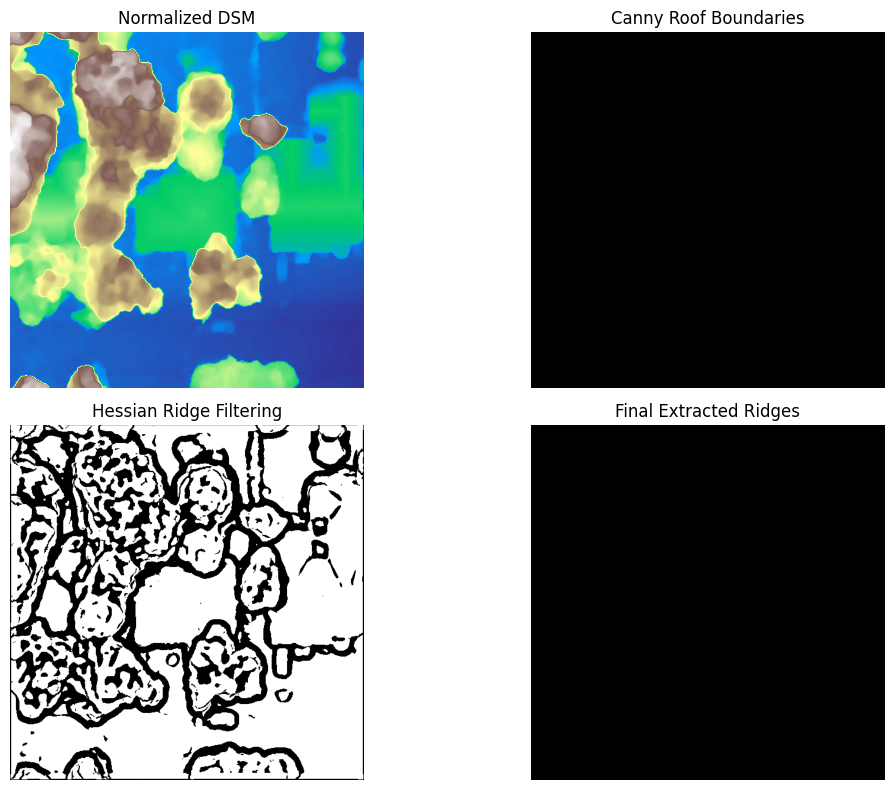

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from skimage.filters import hessian



def extract_ridges(dsm):
    """ Extract roof ridges using Hessian filtering and adaptive enhancement. """
    h, w = dsm.shape

    # 🔹 Step 1: Canny Edge Detection (Find Roof Boundaries)
    canny_edges = cv2.Canny(dsm.astype(np.uint8), 100, 150)

    # 🔹 Step 2: Remove Outer Boundaries (Fill Edges to Create a Building Mask)
    contours, _ = cv2.findContours(canny_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    building_mask = np.zeros_like(canny_edges)
    cv2.drawContours(building_mask, contours, -1, (255), thickness=cv2.FILLED)  # Fill buildings

    # 🔹 Step 3: Apply Hessian Filter (Detects Thin Ridge Structures)
    hessian_filtered = hessian(dsm, sigmas=[.1, .5, 3], mode='constant', cval=0)
    hessian_filtered = (hessian_filtered * 255).astype(np.uint8)  # Normalize

    # 🔹 Step 4: Extract Only Internal Ridges by Removing Outer Edges
    ridge_map = cv2.bitwise_and(hessian_filtered, building_mask)

    # 🔹 Step 5: Post-Processing to Strengthen Ridges
    kernel = np.ones((3, 3), np.uint8)
    ridge_map = cv2.dilate(ridge_map, kernel, iterations=3)  # Slightly widen ridges

    return ridge_map, canny_edges, building_mask, hessian_filtered



# 🔹 Extract Roof Ridges
ridge_map, canny_edges, building_mask, hessian_filtered = extract_ridges(dsm)

# 🔹 Visualization
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(dsm, cmap="terrain")
plt.title("Normalized DSM")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(canny_edges, cmap="gray")
plt.title("Canny Roof Boundaries")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(hessian_filtered, cmap="gray")
plt.title("Hessian Ridge Filtering")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(ridge_map, cmap="gray")
plt.title("Final Extracted Ridges")
plt.axis("off")

plt.tight_layout()
plt.show()


Imposing the outer boundries map on the extracted ridges and using dsm to grow disconnected edges when there is elevation values in the dsm 

Overlaying the outer boundaries mask on top of the output mask first

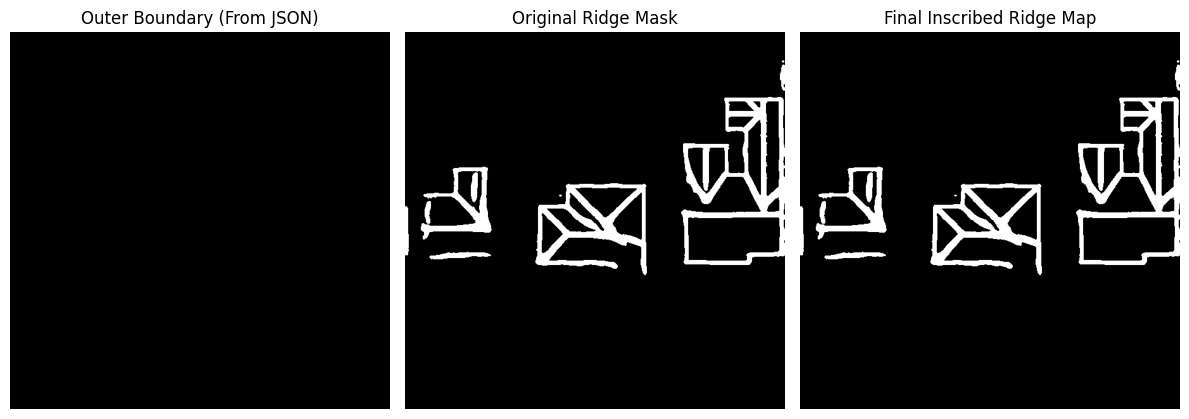

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json

def load_outer_boundary_mask(json_path, image_shape):
    """
    Load outer boundary mask from JSON and convert it to a binary mask.
    
    Parameters:
    - json_path: Path to the JSON file containing building polygon
    - image_shape: (H, W) shape of the output mask
    
    Returns:
    - Binary mask with outer boundaries marked as 1
    """
    with open(json_path, 'r') as f:
        annotations = json.load(f)

    mask = np.zeros(image_shape, dtype=np.uint8)

    for obj in annotations['shapes']:
        if obj['label'] == 'building':  # Ensure it's the correct object
            polygon = np.array(obj['points'], dtype=np.int32)  # Convert to NumPy array
            cv2.fillPoly(mask, [polygon], 1)  # Draw filled building polygon

    return mask

def complete_outer_boundary(outer_mask, ridge_mask):
    """
    Ensures the outer boundary is completely defined and inserts ridge lines inside.

    Parameters:
    - outer_mask: Binary mask of the building boundary (1 = building, 0 = outside)
    - ridge_mask: Binary mask of detected ridges (1 = ridge, 0 = no ridge)

    Returns:
    - Completed mask with outer boundaries and inscribed ridge lines.
    """
    # 🔹 Ensure Binary Masks
    outer_mask = (outer_mask > 0).astype(np.uint8)
    ridge_mask = (ridge_mask > 0).astype(np.uint8)

    # 🔹 Step 1: Extract & Ensure Closed Outer Boundary
    contours, _ = cv2.findContours(outer_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    complete_outer = np.zeros_like(outer_mask)
    cv2.drawContours(complete_outer, contours, -1, (1), thickness=2)  # Redraw boundary

    # 🔹 Step 2: Overlay Ridge Lines Inside the Outer Boundary
    final_mask = np.maximum(complete_outer, ridge_mask)

    return final_mask

# 🔹 Load Outer Boundary JSON
json_path = "32.884040299999995_-96.64130139999999_nearmap_rgb.json"  # Replace with actual JSON file path
#ridge_mask_path = "your_ridge_mask.png"  # Replace with actual ridge segmentation mask

# 🔹 Load Ridge Mask
ridge_mask = cleaned
image_shape = ridge_mask.shape  # Ensure the outer boundary mask has the same dimensions

# 🔹 Convert JSON Polygon to Mask
outer_mask = load_outer_boundary_mask(json_path, image_shape)

# 🔹 Complete the Outer Boundary and Inscribe Ridge Lines
final_mask = complete_outer_boundary(outer_mask, ridge_mask)

# 🔹 Visualization
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(outer_mask, cmap="gray")
plt.title("Outer Boundary (From JSON)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(ridge_mask, cmap="gray")
plt.title("Original Ridge Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(final_mask, cmap="gray")
plt.title("Final Inscribed Ridge Map")
plt.axis("off")

plt.tight_layout()
plt.show()


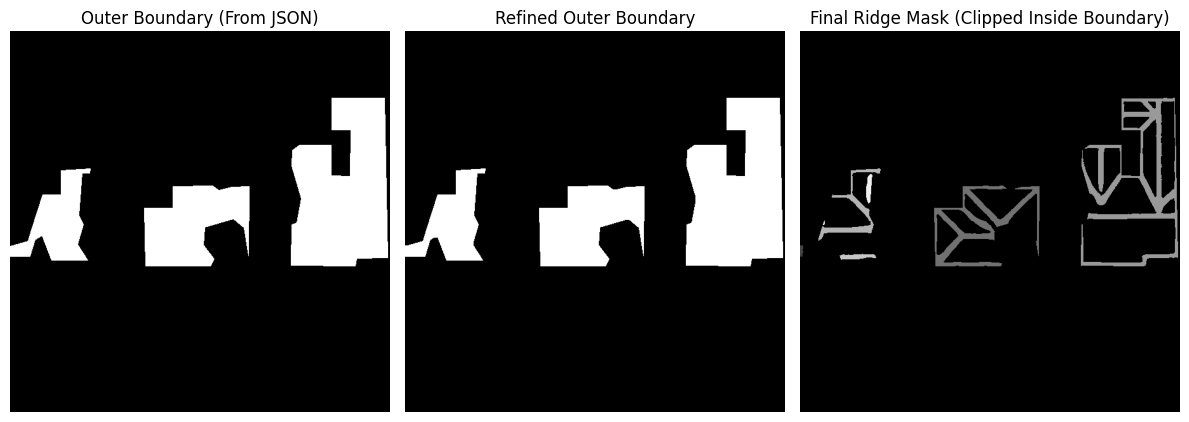

In [10]:
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

def load_outer_boundary_mask(json_path, image_shape):
    """
    Load outer boundary polygon from JSON and convert it to a binary mask.

    Parameters:
    - json_path: Path to the JSON file containing building polygon.
    - image_shape: (Height, Width) of the output mask.

    Returns:
    - Binary mask with outer boundaries marked as 1.
    """
    with open(json_path, 'r') as f:
        annotations = json.load(f)

    mask = np.zeros(image_shape, dtype=np.uint8)

    for obj in annotations['shapes']:
        if obj['label'] == 'roof':  # Ensure it's the correct object
            polygon = np.array(obj['points'], dtype=np.int32)  # Convert to NumPy array
            cv2.fillPoly(mask, [polygon], 1)  # Draw filled building polygon

    return mask

def refine_outer_boundary(outer_mask):
    """
    Refine the outer boundary by closing gaps and ensuring smooth edges.

    Parameters:
    - outer_mask: Binary mask of the building boundary.

    Returns:
    - Closed and refined outer boundary mask.
    """
    kernel = np.ones((5, 5), np.uint8)  # Adjust kernel size based on gaps
    refined_mask = cv2.morphologyEx(outer_mask, cv2.MORPH_CLOSE, kernel)  # Close small gaps
    return refined_mask

def clip_edges_inside_boundary(ridge_mask, outer_mask):
    """
    Clips edges that extend beyond the outer boundary.

    Parameters:
    - ridge_mask: Binary mask of detected ridges (1 = ridge, 0 = no ridge).
    - outer_mask: Binary mask of the building boundary.

    Returns:
    - Ridge mask clipped within the outer boundary.
    """

    return cv2.bitwise_and(ridge_mask.astype(np.uint8) * 255, outer_mask.astype(np.uint8) * 255)  # Remove ridges outside the boundary

# 🔹 Load Data
json_path = "32.884040299999995_-96.64130139999999_nearmap_rgb.json"  # Replace with actual JSON file path
ridge_mask_path = "32.884040299999995_-96.64130139999999_nearmap_rgb_connected.png"  # Replace with actual ridge segmentation mask

# 🔹 Load Ridge Mask
ridge_mask = cv2.imread(ridge_mask_path, cv2.IMREAD_GRAYSCALE)
image_shape = ridge_mask.shape  # Ensure the mask has the same dimensions

# 🔹 Convert JSON Polygon to Outer Boundary Mask
outer_mask = load_outer_boundary_mask(json_path, image_shape)

# 🔹 Close Gaps in Outer Boundary
refined_outer = refine_outer_boundary(outer_mask)

# 🔹 Clip Ridge Edges to Stay Inside the Building
clipped_ridge_mask = clip_edges_inside_boundary(ridge_mask, refined_outer)

# 🔹 Visualization
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(outer_mask, cmap="gray")
plt.title("Outer Boundary (From JSON)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(refined_outer, cmap="gray")
plt.title("Refined Outer Boundary")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(clipped_ridge_mask, cmap="gray")
plt.title("Final Ridge Mask (Clipped Inside Boundary)")
plt.axis("off")

plt.tight_layout()
plt.show()


Unique values in Clipped Ridge Mask before processing: [  0  51  84 114 133 147 178 190]
Unique values in Connected Ridge Mask: [  0 255]


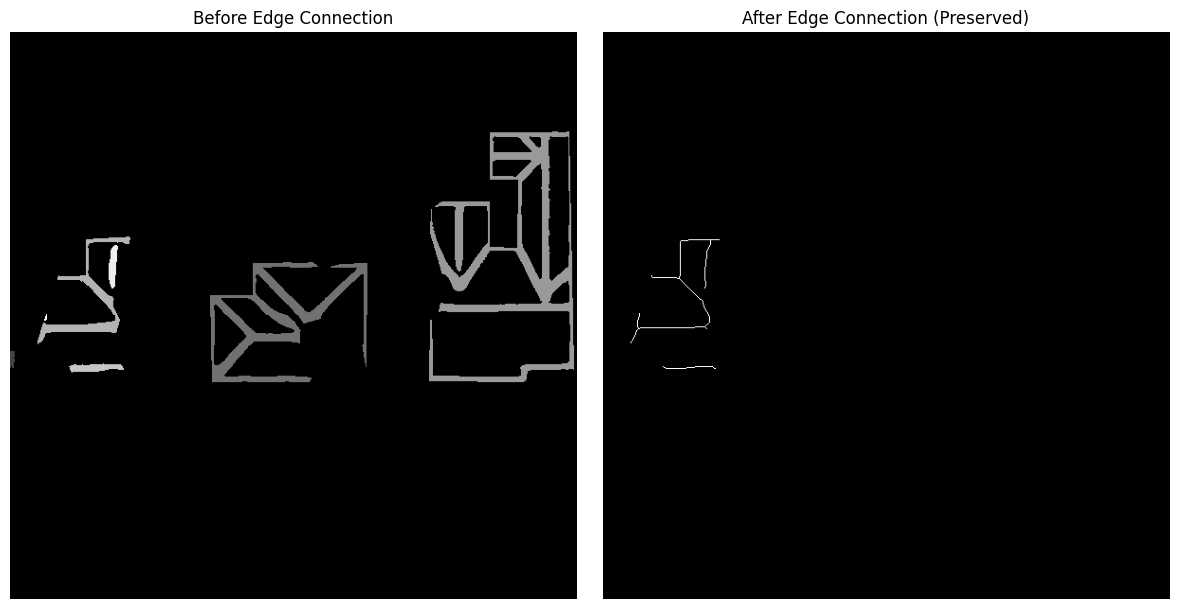

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize

def connect_edges(ridge_mask, kernel_size=3, iterations=1, dilate_before_skeleton=True):
    """
    Connects unconnected edges in a binary mask using morphological operations and skeletonization,
    while preserving valid structures.

    Parameters:
    - ridge_mask: Binary image (0-255) containing disconnected edges.
    - kernel_size: Size of the structuring element for morphological closing.
    - iterations: Number of dilation + erosion cycles.
    - dilate_before_skeleton: Whether to slightly dilate edges before skeletonization.

    Returns:
    - Connected edge mask.
    """
    # 🔹 Step 1: Ensure mask is not empty
    if ridge_mask is None or np.max(ridge_mask) == 0:
        raise ValueError("Error: The input ridge mask is empty. Check if previous steps generated data.")

    # 🔹 Step 2: Ensure the mask is binary (0 or 255)
    ridge_mask = cv2.threshold(ridge_mask, 127, 255, cv2.THRESH_BINARY)[1]

    # 🔹 Step 3: Morphological Closing (Bridges Small Gaps Without Removing Ridges)
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    closed_mask = cv2.morphologyEx(ridge_mask, cv2.MORPH_CLOSE, kernel, iterations=iterations)

    # 🔹 Step 4: Slightly Dilate Before Skeletonization (To Prevent Disappearing Edges)
    if dilate_before_skeleton:
        closed_mask = cv2.dilate(closed_mask, kernel, iterations=1)  # Helps preserve small details

    # 🔹 Step 5: Skeletonization (Preserve Only Essential Structures)
    skeleton = skeletonize(closed_mask // 255)  # Convert to boolean and apply skeletonization
    skeleton = (skeleton * 255).astype(np.uint8)  # Convert back to uint8 format

    return skeleton

# 🔹 Use the Clipped Ridge Mask Created Previously
print("Unique values in Clipped Ridge Mask before processing:", np.unique(clipped_ridge_mask))

# 🔹 Apply Edge Connection
connected_edges = connect_edges(clipped_ridge_mask, kernel_size=3, iterations=1, dilate_before_skeleton=True)

# 🔹 Check the Output
print("Unique values in Connected Ridge Mask:", np.unique(connected_edges))

# 🔹 Visualization
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(clipped_ridge_mask, cmap="gray")
plt.title("Before Edge Connection")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(connected_edges, cmap="gray")
plt.title("After Edge Connection (Preserved)")
plt.axis("off")

plt.tight_layout()
plt.show()


Unique values in Ridge Mask: [  0  66  78  93 107 109 123 142 166 172 205]


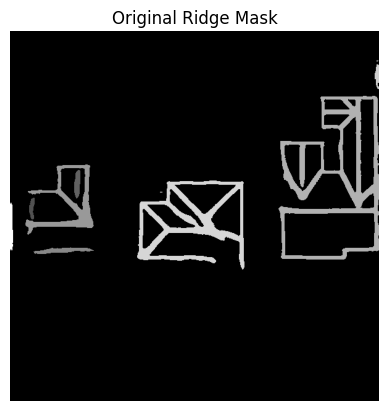

In [12]:
print("Unique values in Ridge Mask:", np.unique(ridge_mask))
plt.imshow(ridge_mask, cmap="gray")
plt.title("Original Ridge Mask")
plt.axis("off")
plt.show()

Unique values in Outer Mask: [0 1]


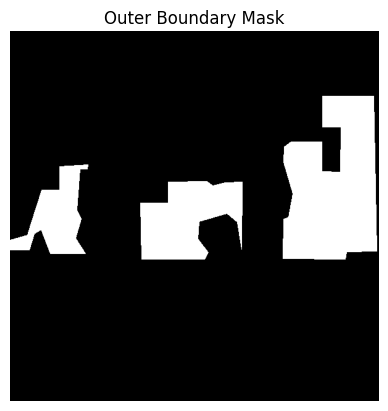

In [13]:
print("Unique values in Outer Mask:", np.unique(outer_mask))
plt.imshow(outer_mask, cmap="gray")
plt.title("Outer Boundary Mask")
plt.axis("off")
plt.show()

In [14]:
# import cv2
# import numpy as np
# import rasterio
# import matplotlib
# import matplotlib.pyplot as plt

# # 🔹 Force Interactive Matplotlib Backend (Ensures Window Opens)
# matplotlib.use("TkAgg")

# # 🔹 Global variables for interactive updates
# image = None  # Stores the loaded image
# fig, ax = None, None
# text_annotation = None
# dsm_mode = False  # Flag for handling single-channel DSM images

# def load_image(image_path):
#     """
#     Loads an image from a file (supports PNG, JPG, and GeoTIFF).
    
#     - If DSM (GeoTIFF), reads as a single-band grayscale image.
#     - If RGB (JPG/PNG), loads as a 3-channel color image.
    
#     Returns:
#     - Loaded image as NumPy array.
#     - Flag indicating if it's a DSM (single-channel).
#     """
#     global dsm_mode

#     if image_path.endswith(".tif"):  # DSM case (GeoTIFF)
#         with rasterio.open(image_path) as dataset:
#             img = dataset.read(1).astype(np.float32)  # Read first band (grayscale)
#         dsm_mode = True  # Set flag for DSM mode
#     else:  # RGB case (JPG, PNG)
#         img = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Load RGB image
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
#         dsm_mode = False

#     return img

# def on_hover(event):
#     """
#     Mouse event callback to display pixel values dynamically inside the image.
#     """
#     global text_annotation

#     if event.xdata is not None and event.ydata is not None:
#         x, y = int(event.xdata), int(event.ydata)  # Convert to integer coordinates

#         if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:  # Ensure within bounds
#             pixel_value = image[y, x]

#             if dsm_mode:  # DSM: Single-channel
#                 text = f"X: {x}, Y: {y}, Elevation: {pixel_value:.2f}"
#             else:  # RGB: 3-channel
#                 text = f"X: {x}, Y: {y}, RGB: {tuple(pixel_value)}"

#             # Remove previous annotation
#             if text_annotation:
#                 text_annotation.remove()

#             # Add new annotation
#             text_annotation = ax.text(10, 30, text, color="white", fontsize=12, 
#                                       bbox=dict(facecolor="black", alpha=0.5))

#             fig.canvas.draw_idle()  # Update figure dynamically

# def interactive_pixel_viewer(image_path):
#     """
#     Opens an interactive Matplotlib window where pixel values are shown on mouse hover.
#     """
#     global image, fig, ax, text_annotation
#     image = load_image(image_path)  # Load the image

#     # 🔹 Create Figure and Display Image
#     fig, ax = plt.subplots(figsize=(8, 8))
#     ax.imshow(image, cmap="gray" if dsm_mode else None)
#     ax.set_title("Interactive Pixel Viewer")
#     ax.axis("off")

#     # 🔹 Initialize Text Annotation
#     text_annotation = ax.text(10, 30, "", color="white", fontsize=12, 
#                               bbox=dict(facecolor="black", alpha=0.5))

#     # 🔹 Connect Mouse Hover Event
#     fig.canvas.mpl_connect("motion_notify_event", on_hover)

#     # 🔹 Show the Window Without Blocking
#     plt.show(block=False)

#     # 🔹 Keep the Window Open and Responsive
#     while plt.fignum_exists(fig.number):  
#         plt.pause(0.1)
#         fig.canvas.flush_events()  # Ensure real-time updates

# # 🔹 Example Usage
# image_path = "masked_dsm.tif"  # Replace with actual image file (RGB or DSM)
# #interactive_pixel_viewer(image_path)


#32.884040299999995_-96.64130139999999_nearmap_dsm.tif
#masked_dsm.tif

Using masked dsm would do fine as there are elevation values where there are edges or rodges


Iteration 1: Added 5521 new pixels
Iteration 2: Added 5408 new pixels
Iteration 3: Added 5345 new pixels
Iteration 4: Added 5164 new pixels
Iteration 5: Added 4951 new pixels


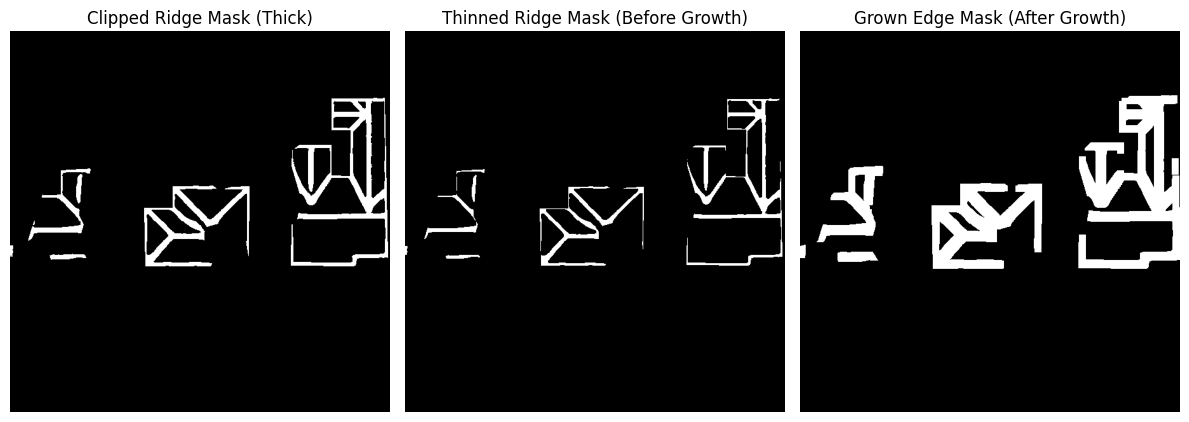

In [22]:
import cv2
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation

def load_dsm(dsm_path):
    """
    Loads a DSM file and replaces NaN values.
    """
    with rasterio.open(dsm_path) as dataset:
        dsm = dataset.read(1).astype(np.float32)  # Read DSM as float32
        dsm = np.nan_to_num(dsm, nan=np.nanmean(dsm))  # Replace NaNs with mean elevation
    return dsm

def thin_edges(edge_mask, iterations=1):
    """
    Thins thick edges to a more skeleton-like structure before growth.
    """
    kernel = np.ones((3, 3), np.uint8)
    return cv2.erode(edge_mask, kernel, iterations=iterations)

def grow_edges(edge_mask, dsm, elevation_threshold=1.5, max_iterations=2):
    """
    Expands edges based on elevation consistency from the DSM.

    Parameters:
    - edge_mask: Binary edge mask (1 = edge, 0 = background)
    - dsm: DSM array with elevation values
    - elevation_threshold: Maximum allowed elevation change for growth
    - max_iterations: Number of growth iterations

    Returns:
    - Updated edge mask with grown edges
    """
    if np.sum(edge_mask) == 0:
        raise ValueError("Error: The clipped ridge mask is empty. Ensure edges are detected.")

    grown_mask = edge_mask.copy()  # Start with initial edge map
    h, w = edge_mask.shape

    # Define 8-directional kernel for neighbor search
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]], dtype=np.uint8)

    for iteration in range(max_iterations):
        expanded = binary_dilation(grown_mask, structure=kernel).astype(np.uint8)
        new_candidates = expanded - grown_mask  # Find newly added edge pixels

        added_pixels = 0  # Track how many pixels are added per iteration

        for y, x in zip(*np.where(new_candidates == 1)):
            neighbors = dsm[max(0, y-1):min(h, y+2), max(0, x-1):min(w, x+2)]
            edge_neighbors = grown_mask[max(0, y-1):min(h, y+2), max(0, x-1):min(w, x+2)]

            valid_neighbors = neighbors[edge_neighbors == 1]

            if len(valid_neighbors) > 0:
                min_diff = np.abs(valid_neighbors - dsm[y, x]).min()

                if min_diff <= elevation_threshold:
                    grown_mask[y, x] = 1
                    added_pixels += 1  # Count added pixels

        print(f"Iteration {iteration + 1}: Added {added_pixels} new pixels")

        if added_pixels == 0:
            break  # Stop if no more pixels are added

    return grown_mask

# 🔹 Load Data
dsm_path = "masked_dsm.tif"  # Replace with actual DSM path
#clipped_ridge_mask_path = "your_clipped_ridge_mask.png"  # Clipped ridge mask from previous step

#clipped_ridge_mask = cv2.imread(clipped_ridge_mask_path, cv2.IMREAD_GRAYSCALE)
clipped_ridge_mask = (clipped_ridge_mask > 0).astype(np.uint8)  # Convert to binary (0 or 1)

dsm = load_dsm(dsm_path)  # Load DSM with fixed NaN handling

# 🔹 Thin Edges Before Growth
thinned_ridge_mask = thin_edges(clipped_ridge_mask, iterations=1)

# 🔹 Apply Edge Growth
grown_edge_mask = grow_edges(thinned_ridge_mask, dsm, elevation_threshold=1.5, max_iterations=5)

# 🔹 Visualization
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(clipped_ridge_mask, cmap="gray")
plt.title("Clipped Ridge Mask (Thick)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(thinned_ridge_mask, cmap="gray")
plt.title("Thinned Ridge Mask (Before Growth)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(grown_edge_mask, cmap="gray")
plt.title("Grown Edge Mask (After Growth)")
plt.axis("off")

plt.tight_layout()
plt.show()


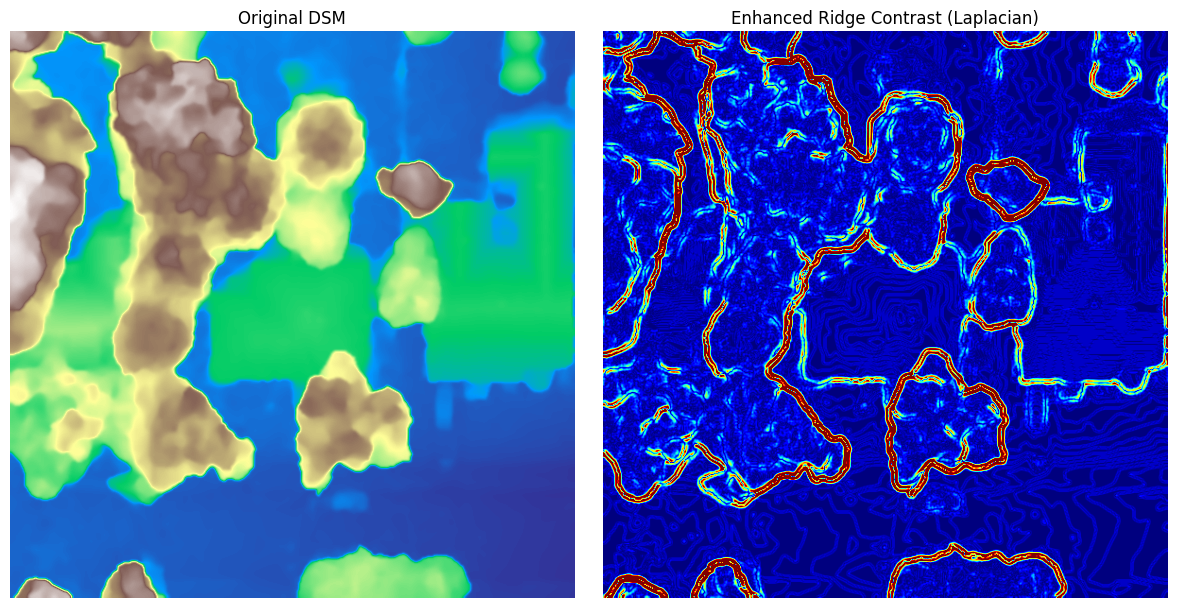

In [35]:
import cv2
import numpy as np
import rasterio
import matplotlib.pyplot as plt

def load_dsm(dsm_path):
    """
    Loads a DSM file and replaces NaN values with the mean elevation.
    """
    with rasterio.open(dsm_path) as dataset:
        dsm = dataset.read(1).astype(np.float32)  # Read as float32
        dsm = np.nan_to_num(dsm, nan=np.nanmean(dsm))  # Replace NaNs with mean
    return dsm

def normalize_dsm(dsm):
    """
    Normalizes the DSM to 0-255 to enhance small elevation differences.
    """
    dsm_min, dsm_max = np.min(dsm), np.max(dsm)
    dsm_normalized = ((dsm - dsm_min) / (dsm_max - dsm_min)) * 255
    return dsm_normalized.astype(np.uint8)

def high_pass_filter(dsm):
    """
    Applies a high-pass filter (Laplacian) to enhance ridges & roof segments.
    """
    laplacian = cv2.Laplacian(dsm, cv2.CV_32F, ksize=5)
    laplacian_abs = cv2.convertScaleAbs(laplacian)  # Convert to 8-bit image
    return laplacian_abs

def visualize_elevation(dsm, filtered_dsm):
    """
    Plots the original DSM and the contrast-enhanced ridge map.
    """
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(dsm, cmap="terrain")
    plt.title("Original DSM")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(filtered_dsm, cmap="jet")  # High-contrast colormap
    plt.title("Enhanced Ridge Contrast (Laplacian)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# 🔹 Load DSM
dsm_path = "32.884040299999995_-96.64130139999999_nearmap_dsm.tif"  # Replace with actual DSM file path
dsm = load_dsm(dsm_path)
dsm_smoothed = cv2.GaussianBlur(dsm, (5,5), 0)

# 🔹 Normalize & Apply High-Pass Filter
dsm_normalized = normalize_dsm(dsm_smoothed)
filtered_dsm = high_pass_filter(dsm_normalized)

# 🔹 Visualize
visualize_elevation(dsm_normalized, filtered_dsm)


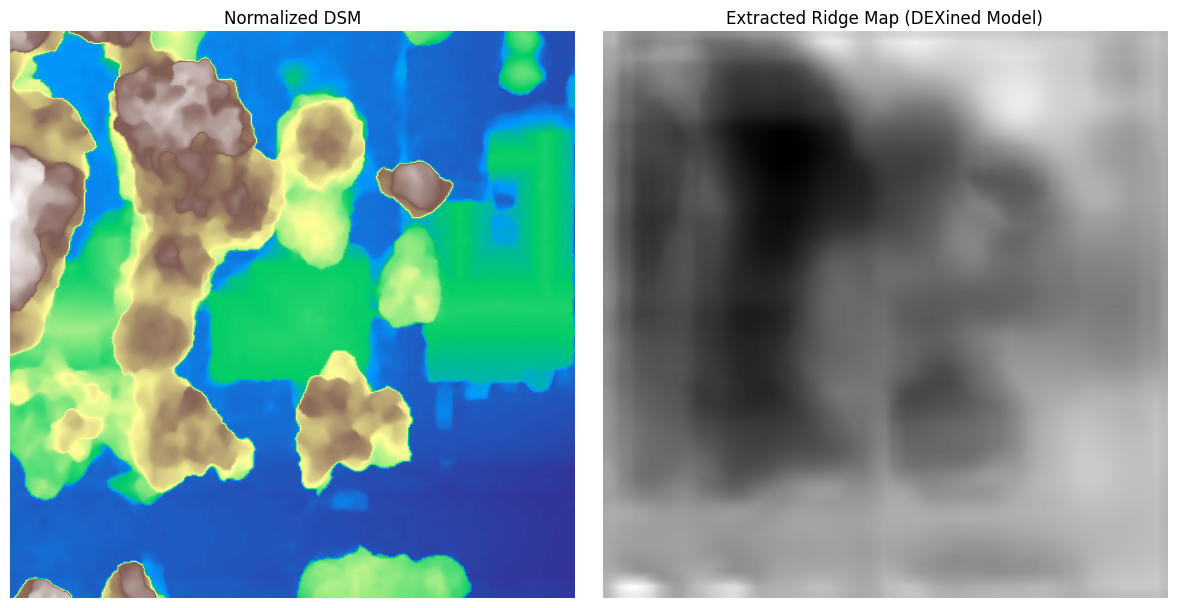

In [38]:
import torch
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from torchvision import models

def load_dsm(dsm_path):
    """Loads a DSM and normalizes it."""
    with rasterio.open(dsm_path) as dataset:
        dsm = dataset.read(1).astype(np.float32)
        dsm = np.nan_to_num(dsm, nan=np.nanmean(dsm))
    return dsm

def normalize_dsm(dsm):
    """Normalize DSM to 0-255 range."""
    dsm_min, dsm_max = np.min(dsm), np.max(dsm)
    dsm_normalized = ((dsm - dsm_min) / (dsm_max - dsm_min)) * 255
    return dsm_normalized.astype(np.uint8)

def apply_dexined(dsm):
    """Uses the pretrained DEXined model to extract fine edges."""
    model = models.segmentation.deeplabv3_resnet50(pretrained=True)
    model.eval()

    # Convert (H, W) → (3, H, W) by stacking DSM in 3 channels
    dsm_3ch = np.stack([dsm, dsm, dsm], axis=0)

    # Convert to Torch tensor and add batch dimension
    input_tensor = torch.tensor(dsm_3ch, dtype=torch.float32).unsqueeze(0)  # (1, 3, H, W)

    with torch.no_grad():
        #output = model(input_tensor)['out'].squeeze(0).squeeze(0).numpy()
        output = model(input_tensor)['out'][0, 0].cpu().numpy() 

    ridge_map = (output - output.min()) / (output.max() - output.min()) * 255
    ridge_map = ridge_map.astype(np.uint8)
    return ridge_map

# Load DSM
dsm_path = "32.884040299999995_-96.64130139999999_nearmap_dsm.tif"
dsm = load_dsm(dsm_path)
dsm_normalized = normalize_dsm(dsm)

# Apply Pretrained DEXined Edge Detection
ridge_map = apply_dexined(dsm_normalized)

# Visualize
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(dsm_normalized, cmap="terrain")
plt.title("Normalized DSM")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ridge_map, cmap="gray")
plt.title("Extracted Ridge Map (DEXined Model)")
plt.axis("off")

plt.tight_layout()
plt.show()


In [39]:
import cv2
import numpy as np
import rasterio
import matplotlib.pyplot as plt

def load_dsm(dsm_path):
    with rasterio.open(dsm_path) as dataset:
        dsm = dataset.read(1).astype(np.float32)
        dsm = np.nan_to_num(dsm, nan=np.nanmean(dsm))
    return dsm

def normalize_dsm(dsm):
    dsm_min, dsm_max = np.min(dsm), np.max(dsm)
    return ((dsm - dsm_min) / (dsm_max - dsm_min) * 255).astype(np.uint8)

# Apply OpenCV SED Edge Detection
def apply_sed_edge_detection(dsm):
    sed = cv2.ximgproc.createStructuredEdgeDetection("model.yml.gz")
    dsm_3ch = cv2.merge([dsm, dsm, dsm])  # Convert to 3-channel
    edges = sed.detectEdges(dsm_3ch.astype(np.float32) / 255.0)
    edges = (edges * 255).astype(np.uint8)  # Convert to 8-bit
    return edges

# Run Process
dsm_path = "32.884040299999995_-96.64130139999999_nearmap_dsm.tif"
dsm = load_dsm(dsm_path)
dsm_normalized = normalize_dsm(dsm)
ridge_map = apply_sed_edge_detection(dsm_normalized)

# Visualize
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(dsm_normalized, cmap="terrain")
plt.title("Normalized DSM")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ridge_map, cmap="gray")
plt.title("Extracted Ridge Map (SED Model)")
plt.axis("off")

plt.show()


AttributeError: module 'cv2' has no attribute 'ximgproc'

In [16]:
# import rasterio
# import numpy as np
# import os

# def split_tiff_into_parts(image_path, output_dir, overlap_ratio=0.2):
#     """
#     Splits an RGB TIFF into 3 overlapping parts and saves them as separate TIFF files.
    
#     Parameters:
#     - image_path: Path to the input RGB TIFF file.
#     - output_dir: Directory to save the split images.
#     - overlap_ratio: Fraction of overlap between adjacent sections.
    
#     Output:
#     - Saves 3 TIFF files with the same size as the original (600x598x3).
#     """
    
#     # 🔹 Load the original RGB TIFF
#     with rasterio.open(image_path) as dataset:
#         rgb_image = dataset.read().transpose(1, 2, 0)  # Convert to (H, W, C)
#         profile = dataset.profile  # Store metadata

#     h, w, c = rgb_image.shape  # Should be (600, 598, 3)
    
#     # 🔹 Define Split Points
#     step = w // 3  # Base width for each part
#     overlap = int(step * overlap_ratio)  # Calculate overlap in pixels

#     split_positions = [
#         (0, step + overlap),  # First part
#         (step - overlap, 2 * step + overlap),  # Middle part
#         (2 * step - overlap, w)  # Last part
#     ]
    
#     # 🔹 Ensure Output Directory Exists
#     os.makedirs(output_dir, exist_ok=True)

#     # 🔹 Save Each Split as a TIFF
#     for i, (start_x, end_x) in enumerate(split_positions):
#         part_image = np.zeros_like(rgb_image)  # Create a blank image
#         part_image[:, :end_x-start_x, :] = rgb_image[:, start_x:end_x, :]  # Place cropped section

#         # 🔹 Update Metadata to Match Original Dimensions
#         profile.update({
#             "height": h,
#             "width": w,
#             "count": c
#         })

#         # 🔹 Save the Split TIFF
#         output_path = os.path.join(output_dir, f"split_part_{i+1}.tif")
#         with rasterio.open(output_path, "w", **profile) as dst:
#             dst.write(part_image.transpose(2, 0, 1))  # Save as (C, H, W)

#         print(f"✅ Saved: {output_path}")

# # 🔹 Example Usage
# image_path = "32.884040299999995_-96.64130139999999_nearmap_rgb.tif"  # Replace with actual TIFF path
# output_dir = "E:\Proto\Ridgewise\Post_processing"
# split_tiff_into_parts(image_path, output_dir)


In [17]:
# import cv2
# import numpy as np
# import os

# def merge_masks(split_masks_dir, output_mask_path, overlap_ratio=0.2):
#     """
#     Merges 3 overlapping model-generated masks (PNG) into a single full-sized mask.

#     Parameters:
#     - split_masks_dir: Directory containing the 3 masks from inference.
#     - output_mask_path: Path to save the merged mask.
#     - overlap_ratio: The same overlap used in the initial split.

#     Output:
#     - Saves a merged mask of size (600, 598) in PNG format.
#     """

#     # 🔹 Load all split masks (ensure correct sorting & valid files)
#     mask_files = sorted([os.path.join(split_masks_dir, f) for f in os.listdir(split_masks_dir) if f.endswith('.png')])

#     print("📝 Found Mask Files:", mask_files)  # Debug print

#     if len(mask_files) != 3:
#         raise ValueError(f"Error: Expected 3 mask files, but found {len(mask_files)}.\nFiles found: {mask_files}")

#     masks = []
#     for mask_file in mask_files:
#         mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
#         masks.append(mask)

#     # 🔹 Define Merge Parameters
#     h, w = masks[0].shape  # Each mask should be (600, 598)
#     step = w // 3  # Base width of each part
#     overlap = int(step * overlap_ratio)  # Overlapping pixels

#     # 🔹 Initialize Final Mask (Empty)
#     final_mask = np.zeros((h, w), dtype=np.uint8)

#     # 🔹 Define Split Positions (Same as During Splitting)
#     split_positions = [
#         (0, step + overlap),  # First part
#         (step - overlap, 2 * step + overlap),  # Middle part
#         (2 * step - overlap, w)  # Last part
#     ]

#     # 🔹 Merge Masks Smartly (Handling Overlaps)
#     merge_weight = np.linspace(1, 0, overlap)  # Weighting for smooth blending

#     for i, (start_x, end_x) in enumerate(split_positions):
#         mask_part = masks[i]

#         if i == 0:  # Left-most part
#             final_mask[:, start_x:end_x] = mask_part[:, :end_x-start_x]

#         elif i == 1:  # Middle part (Overlapping region blending)
#             blend_region = final_mask[:, start_x:start_x+overlap] * merge_weight + mask_part[:, :overlap] * (1 - merge_weight)
#             final_mask[:, start_x:start_x+overlap] = blend_region.astype(np.uint8)
#             final_mask[:, start_x+overlap:end_x] = mask_part[:, overlap:end_x-start_x]

#         elif i == 2:  # Right-most part
#             blend_region = final_mask[:, start_x:start_x+overlap] * merge_weight + mask_part[:, :overlap] * (1 - merge_weight)
#             final_mask[:, start_x:start_x+overlap] = blend_region.astype(np.uint8)
#             final_mask[:, start_x+overlap:end_x] = mask_part[:, overlap:end_x-start_x]

#     # 🔹 Save the Merged Mask as PNG
#     cv2.imwrite(output_mask_path, final_mask)
#     print(f"✅ Merged mask saved to: {output_mask_path}")

# # 🔹 Example Usage
# split_masks_dir = "split_masks"  # Directory where the 3 masks are saved
# output_mask_path = "merged_mask.png"  # Final combined mask output
# merge_masks(split_masks_dir, output_mask_path)


Trying what nearly worked on just google dsm

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor
from skimage.segmentation import slic, watershed
from skimage.util import img_as_ubyte

def dsm_to_point_cloud(dsm):
    """ Convert DSM to 3D point cloud (x, y, height). """
    h, w = dsm.shape
    x, y = np.meshgrid(np.arange(w), np.arange(h))
    points = np.column_stack((x.ravel(), y.ravel(), dsm.ravel()))
    return points, h, w

def fit_planes_ransac_dynamic(points, h, w, min_points=500, threshold=0.3):
    """ Fit planes iteratively using RANSAC """
    planes = []
    inlier_masks = []
    remaining_points = points.copy()

    while len(remaining_points) > min_points:
        model = RANSACRegressor(residual_threshold=threshold)
        model.fit(remaining_points[:, :2], remaining_points[:, 2])  

        inliers = model.inlier_mask_
        if np.sum(inliers) < min_points:
            break

        planes.append(model.estimator_.coef_)
        inlier_mask = np.zeros((h, w), dtype=bool)
        x_idx = np.clip(remaining_points[:, 0].astype(int), 0, w - 1)
        y_idx = np.clip(remaining_points[:, 1].astype(int), 0, h - 1)
        inlier_mask[y_idx, x_idx] = inliers
        inlier_masks.append(inlier_mask)

        remaining_points = remaining_points[~inliers]

    return planes, inlier_masks

def extract_ridges(dsm, inlier_masks):
    """ Extract inner roof ridges using multi-scale filters and segmentation. """
    h, w = dsm.shape
    ridge_map = np.zeros((h, w), dtype=np.uint8)

    # Ensure DSM is float32 for OpenCV filters
    dsm = dsm.astype(np.float32)

    # Multi-scale gradient filtering
    grad_x_small = cv2.Sobel(dsm, cv2.CV_32F, 1, 0, ksize=3)
    grad_y_small = cv2.Sobel(dsm, cv2.CV_32F, 0, 1, ksize=3)
    grad_x_large = cv2.Sobel(dsm, cv2.CV_32F, 1, 0, ksize=7)
    grad_y_large = cv2.Sobel(dsm, cv2.CV_32F, 0, 1, ksize=7)

    # Combine multi-scale gradients
    gradient_magnitude = np.sqrt((grad_x_small**2 + grad_y_small**2) + (grad_x_large**2 + grad_y_large**2))

    # Adaptive thresholding to capture ridges
    ridge_threshold = np.percentile(gradient_magnitude, 85)
    ridge_map[gradient_magnitude > ridge_threshold] = 255

    # Laplacian to enhance inner edges
    laplacian = cv2.Laplacian(dsm, cv2.CV_32F, ksize=3)
    laplacian = cv2.convertScaleAbs(laplacian)
    ridge_map = np.maximum(ridge_map, laplacian)

    # Apply SLIC segmentation for refined ridge grouping
    num_segments = max(h * w // 500, 150)
    slic_segments = slic(dsm, n_segments=num_segments, compactness=10, start_label=0, channel_axis=None)

    # Use watershed segmentation on SLIC edges
    markers = slic_segments + 1
    watershed_segmentation = watershed(-ridge_map, markers, mask=ridge_map > 0)

    return watershed_segmentation

# Load masked DSM
# dsm_masked = np.load("your_masked_dsm.npy")

# Convert to point cloud
points, h, w = dsm_to_point_cloud(dsm_masked)

# Adaptive RANSAC Plane Extraction
planes, inlier_masks = fit_planes_ransac_dynamic(points, h, w, min_points=500, threshold=0.3)

# Extract ridges
ridge_map = extract_ridges(dsm_masked, inlier_masks)

# Visualize
plt.figure(figsize=(8, 6))
plt.imshow(ridge_map, cmap='gray')
plt.title("Enhanced Inner Roof Ridges")
plt.axis('off')
plt.show()

Figuring out the kinda nopise in dsm
doing this for masked first

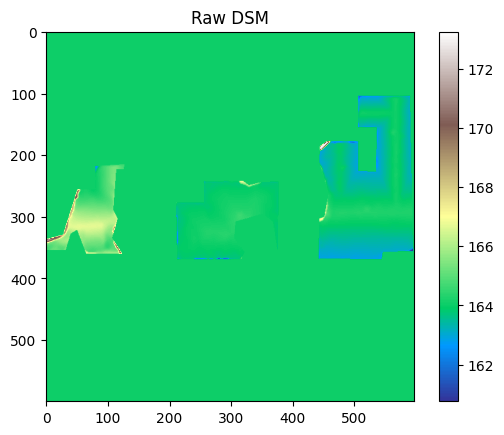

In [14]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
def load_dsm(dsm_path):
    with rasterio.open(dsm_path) as dataset:
        dsm = dataset.read(1).astype(np.float32)
        dsm = np.nan_to_num(dsm, nan=np.nanmean(dsm))
    return dsm
dsm_masked=load_dsm("masked_dsm.tif")

plt.imshow(dsm_masked, cmap='terrain')
plt.colorbar()
plt.title('Raw DSM')
plt.show()


160.75768


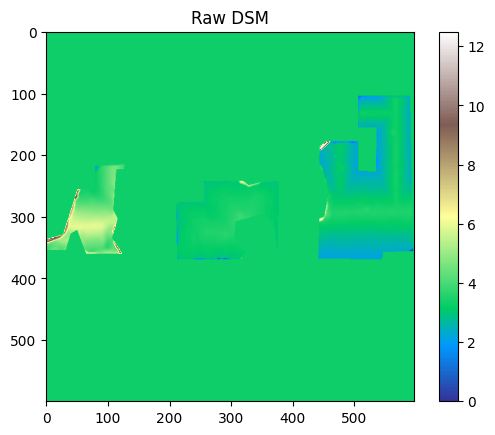

In [17]:
print(np.min(dsm_masked))
dsm_experimnetal=dsm_masked-np.min(dsm_masked)


plt.imshow(dsm_experimnetal, cmap='terrain')
plt.colorbar()
plt.title('Raw DSM')
plt.show()



The noise seems to be stripping and banding - bands on the image
loss of details about slopes

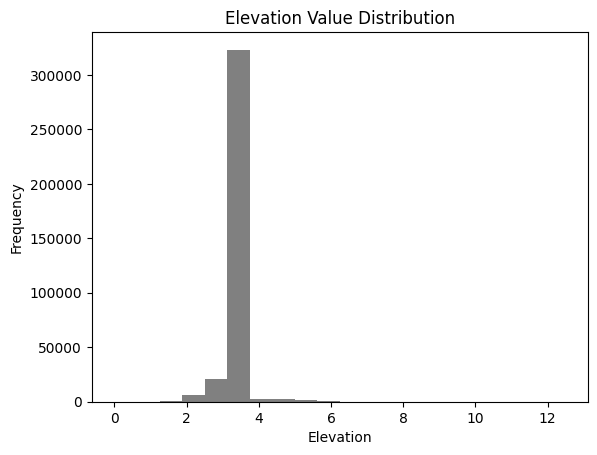

In [18]:
plt.hist(dsm_experimnetal.flatten(), bins=20, color='gray')
plt.title("Elevation Value Distribution")
plt.xlabel("Elevation")
plt.ylabel("Frequency")
plt.show()

High pass filtering to highlight noise patterns

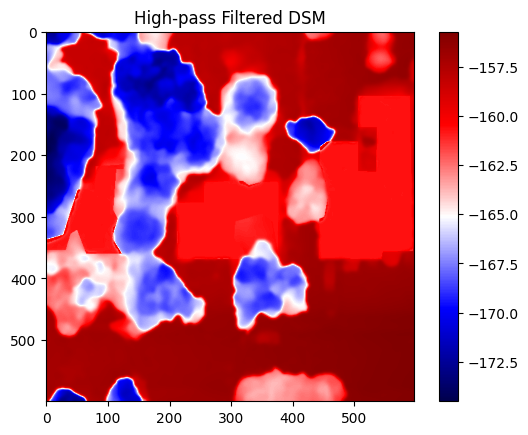

In [19]:
import scipy.ndimage as ndi

dsm_high_pass = dsm_experimnetal - ndi.gaussian_filter(dsm, sigma=2)
plt.imshow(dsm_high_pass, cmap='seismic')
plt.title('High-pass Filtered DSM')
plt.colorbar()
plt.show()


Spatial Gradient map

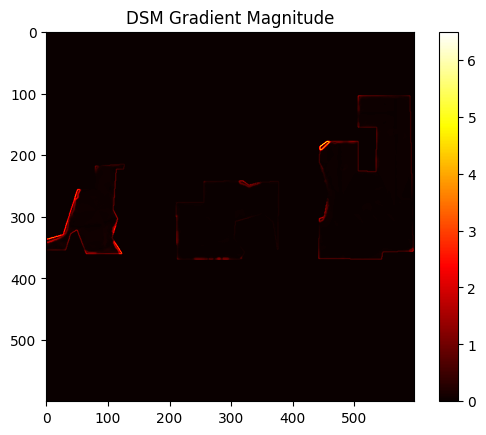

In [20]:
gx, gy = np.gradient(dsm_experimnetal)
grad_mag = np.sqrt(gx**2 + gy**2)

plt.imshow(grad_mag, cmap='hot')
plt.title('DSM Gradient Magnitude')
plt.colorbar()
plt.show()


Local standard deviation

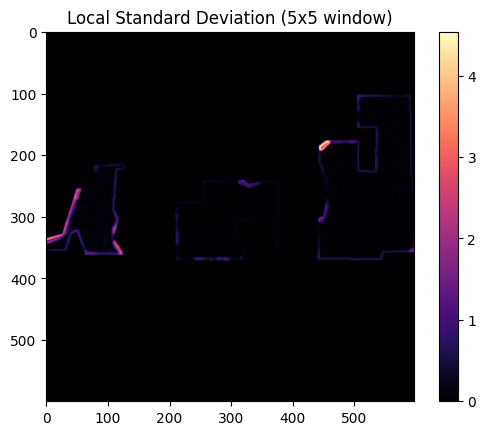

In [21]:
from scipy.ndimage import generic_filter

# Define the function for local std
def local_std(arr):
    return np.nanstd(arr)

# Apply the function over a 5x5 window (or whatever you prefer)
local_std_map = generic_filter(dsm_experimnetal, local_std, size=5, mode='nearest')

# Visualize
plt.imshow(local_std_map, cmap='magma')
plt.title('Local Standard Deviation (5x5 window)')
plt.colorbar()
plt.show()


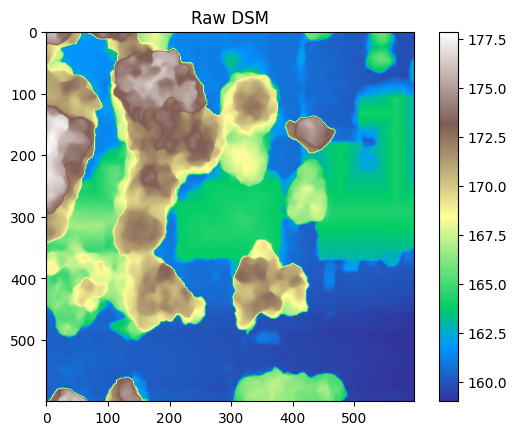

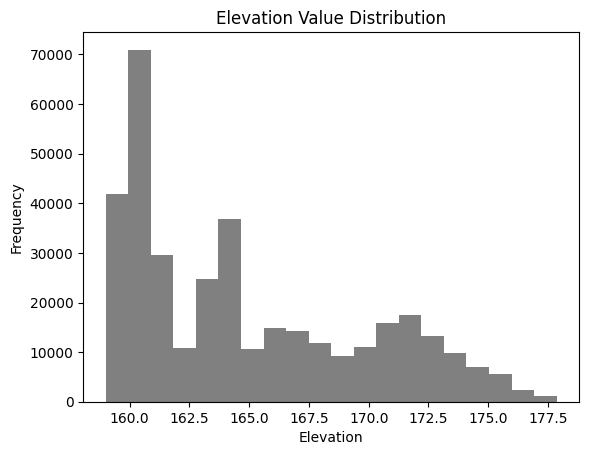

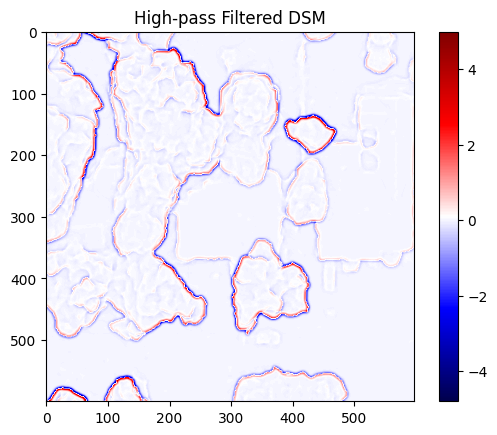

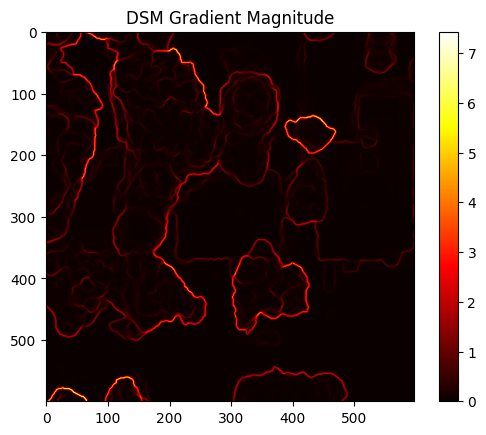

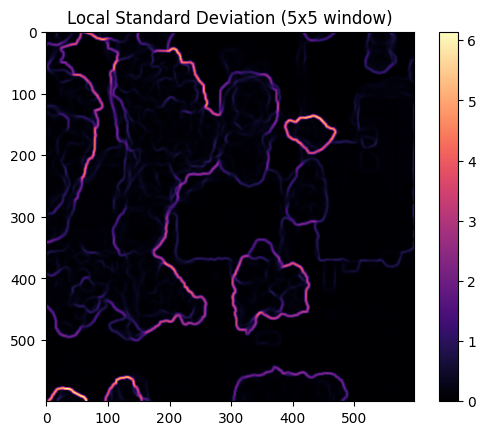

In [12]:
import scipy.ndimage as ndi
from scipy.ndimage import generic_filter
import rasterio
import numpy as np
import matplotlib.pyplot as plt

#------Load DSM -----#
def load_dsm(dsm_path):
    with rasterio.open(dsm_path) as dataset:
        dsm = dataset.read(1).astype(np.float32)
        dsm = np.nan_to_num(dsm, nan=np.nanmean(dsm))
    return dsm
dsm=load_dsm("32.884040299999995_-96.64130139999999_nearmap_dsm.tif")

#------Terrain plot-----#

plt.imshow(dsm, cmap='terrain')
plt.colorbar()
plt.title('Raw DSM')
plt.show()


#----Histogram Map-----#
plt.hist(dsm.flatten(), bins=20, color='gray')
plt.title("Elevation Value Distribution")
plt.xlabel("Elevation")
plt.ylabel("Frequency")
plt.show()

#------High Pass Filtering-----#


dsm_high_pass = dsm - ndi.gaussian_filter(dsm, sigma=2)
plt.imshow(dsm_high_pass, cmap='seismic')
plt.title('High-pass Filtered DSM')
plt.colorbar()
plt.show()


#------Spatial Gradien Map-----#
gx, gy = np.gradient(dsm)
grad_mag = np.sqrt(gx**2 + gy**2)

plt.imshow(grad_mag, cmap='hot')
plt.title('DSM Gradient Magnitude')
plt.colorbar()
plt.show()


#------Local Std Deviation Plot-----#


# Define the function for local std
def local_std(arr):
    return np.nanstd(arr)

# Apply the function over a 5x5 window (or whatever you prefer)
local_std_map = generic_filter(dsm, local_std, size=5, mode='nearest')

# Visualize
plt.imshow(local_std_map, cmap='magma')
plt.title('Local Standard Deviation (5x5 window)')
plt.colorbar()
plt.show()
